# Beach Trash Detector - Final Project

**Description**: Life at the oceans is not as safe as it used to be before human kind started to polute the oceans, beaches and seas. The garbage throw at the beach, usually ends in the ocean and it is harmful to all animals and the enviroment, with that in mind my idea is to develop a computer vision software to recognize trash at the beach, and with the help of a drone recognize this trash and save its locations, so that someone can pickup, or another drones could do that job, why not.



In [2]:
%tensorflow_version 1.15
!pip install keras==2.1.0
import json

DATASET_PATH = 'dataset/'
ANNOTATIONS_JSON = 'annotations.json'
with open(DATASET_PATH + ANNOTATIONS_JSON, 'r') as f:
    dataset = json.loads(f.read())

categories = dataset['categories']
annotations = dataset['annotations']
images = dataset['images']
print(f'categories: {len(categories)}\nannotations: {len(annotations)}\nimages: {len(images)}')

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.15`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.
categories: 60
annotations: 4784
images: 1500


In [3]:
import os.path
import argparse
import json
from PIL import Image
import requests
from io import BytesIO
import sys

nr_images = len(dataset['images'])
for i in range(nr_images):
    image = dataset['images'][i]

    file_name = image['file_name']
    url_original = image['flickr_url']
    url_resized = image['flickr_640_url']

    file_path = os.path.join('dataset', file_name)

    # Create subdir if necessary
    subdir = os.path.dirname(file_path)
    if not os.path.isdir(subdir):
        os.mkdir(subdir)

    if not os.path.isfile(file_path):
        # Load and Save Image
        response = requests.get(url_original)
        img = Image.open(BytesIO(response.content))
        if img._getexif():
            img.save(file_path, exif=img.info["exif"])
        else:
            img.save(file_path)

    # Show loading bar
    bar_size = 30
    x = int(bar_size * i / nr_images)
    sys.stdout.write("%s[%s%s] - %i/%i\r" % ('Loading: ', "=" * x, "." * (bar_size - x), i, nr_images))
    sys.stdout.flush()
    i+=1


In [4]:
with open('dataset/annotations.json', 'r') as f:
    d = json.loads(f.read())
images = [i['file_name'] for i in d['images']]
print(len(images))

1500


In [5]:
from pycocotools.coco import COCO

c = COCO(annotation_file='dataset/annotations.json')

loading annotations into memory...
Done (t=0.07s)
creating index...
index created!


In [6]:
a_0 = c.anns[1]
img = c.imgToAnns[3]
segmentations = []
for i in img:
    x = []
    y = []
    for j, k in enumerate(i['segmentation'][0]):
        if j % 2 ==0:
            x.append(k)
        else:
            y.append(k)
    segmentations.append({'all_x': x, 'all_y': y})
        
#     segmentations += i['segmentation']
print(len(segmentations))


# print(imgs[0][0]['segmentation'])
# [img for img in imgs if img['segmentation']]

4


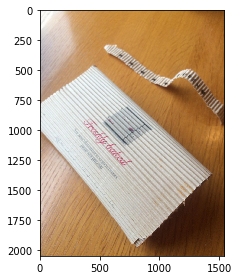

In [7]:
import skimage.io
image = skimage.io.imread("dataset/batch_1/000008.jpg")
skimage.io.imshow(image)

In [8]:
import os
from mrcnn.utils import Dataset
from mrcnn import visualize

class TrashDataset(Dataset):
    def load_dataset(self, dataset_dir, is_train=True):
        # define one class
        self.add_class("dataset", 1, "trash")
        # define data locations
        # find all images
        imgs = list(c.imgToAnns.values())
        if is_train:
            imgs = imgs[:300]
        else:
            imgs = imgs[300:]
        for img in imgs:
            # extract image id
            image_id = img[0]['image_id']
            image_data = c.loadImgs([image_id])[0]
            segmentations = []
            for i in img:
                x = []
                y = []
                for j, k in enumerate(i['segmentation'][0]):
                    if j % 2 ==0:
                        x.append(k)
                    else:
                        y.append(k)
                segmentations.append({'all_points_x': x, 'all_points_y': y})

            image_path = dataset_dir + image_data['file_name']
            height = image_data['height']
            width = image_data['width']        
            if os.path.exists(image_path):
              self.add_image(
                  "dataset",
                  image_id=image_data['file_name'],  # use file name as a unique image id
                  path=image_path,
                  width=width, height=height,
                  polygons=segmentations)
            
    def load_mask(self, image_id):
        """Generate instance masks for an image.
            Returns:
            masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
            class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a balloon dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "dataset":
            return super(self.__class__, self).load_mask(image_id)

        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
            mask[rr, cc, i] = 1

        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        return mask, np.ones([mask.shape[-1]], dtype=np.int32)
    
    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "database":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

In [9]:
dataset = TrashDataset()
dataset.load_dataset(DATASET_PATH, is_train=True)
dataset.prepare()

dataset_val = TrashDataset()
dataset_val.load_dataset(DATASET_PATH, is_train=False)
dataset_val.prepare()

In [10]:
import sys
import itertools
import math
import logging
import json
import re
import random
from collections import OrderedDict
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines
from matplotlib.patches import Polygon

print("Image Count: {}".format(len(dataset.image_ids)))
print("Image Count: {}".format(len(dataset_val.image_ids)))
print("Class Count: {}".format(dataset.num_classes))
for i, info in enumerate(dataset.class_info):
    print("{:3}. {:50}".format(i, info['name']))

Image Count: 300
Image Count: 1200
Class Count: 2
  0. BG                                                
  1. trash                                             


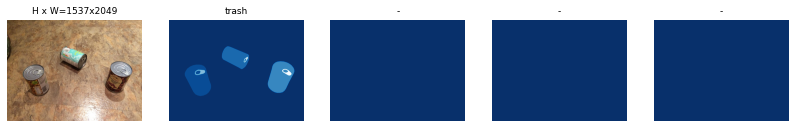

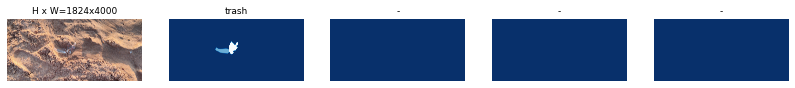

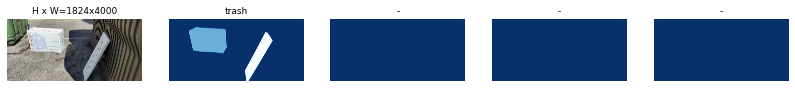

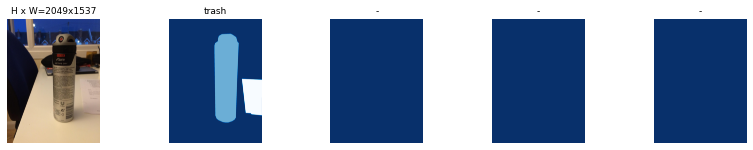

In [11]:
image_ids = np.random.choice(dataset.image_ids, 4)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names)

image_id  96 None


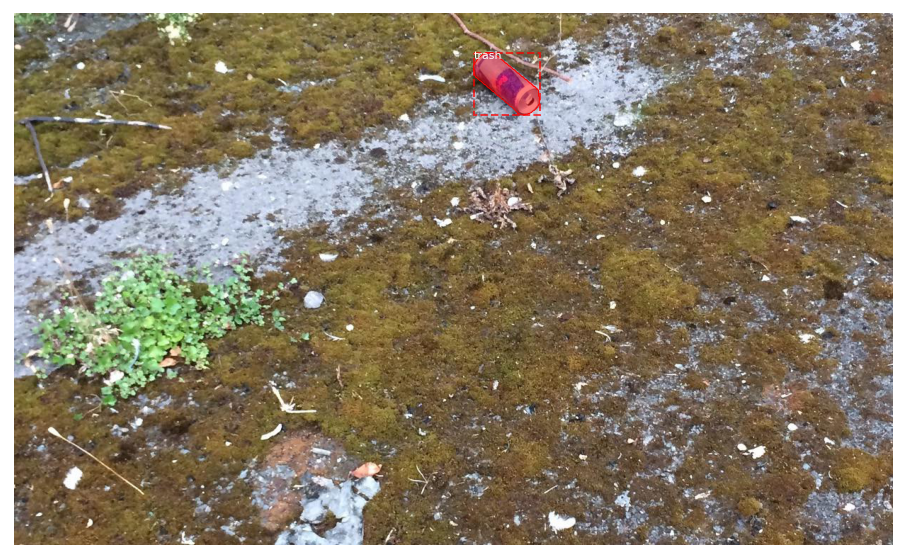

In [12]:
from mrcnn.utils import extract_bboxes

image_id = random.choice(dataset.image_ids)
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)
# Compute Bounding box
bbox = extract_bboxes(mask)

# Display image and additional stats
print("image_id ", image_id, dataset.image_reference(image_id))

# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

In [16]:
from mrcnn.config import Config

class TrashConfig(Config):
    NAME = "TrashConfig"
    BACKBONE_STRIDES = [4, 8, 16, 32, 64]
    RPN_ANCHOR_SCALES = (32, 64, 128, 256, 512)
    RPN_ANCHOR_RATIOS = [0.5, 1, 2]
    NUM_CLASSES = 1 + 1
    IMAGES_PER_GPU = 1
    STEPS_PER_EPOCH = 100

config = TrashConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [17]:
from mrcnn.utils import download_trained_weights

COCO_MODEL_PATH = 'dataset/mask_rcnn_coco.h5'
if not os.path.exists(COCO_MODEL_PATH):
    download_trained_weights(COCO_MODEL_PATH)


In [18]:

from mrcnn import model as modellib
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 
print(tf.__version__)
# Create model object in inference mode.
MODEL_DIR = 'model/'
model = modellib.MaskRCNN(mode="training", model_dir=MODEL_DIR, config=config)
# weights_path = model.find_last()
# print(weights_path)
# model.load_weights(weights_path, by_name=True)

model.load_weights(COCO_MODEL_PATH, by_name=True, exclude=[
            "mrcnn_class_logits", "mrcnn_bbox_fc",
            "mrcnn_bbox", "mrcnn_mask"])
# Load weights trained on MS-COCO
# model.train(dataset, dataset_val,learning_rate=config.LEARNING_RATE, epochs=1,
#                     layers='heads')

Instructions for updating:
non-resource variables are not supported in the long term
1.15.2






Using TensorFlow backend.



Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead








In [19]:
model.train(dataset, dataset_val, learning_rate=config.LEARNING_RATE, epochs=5, layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: model/trashconfig20200719T2123/mask_rcnn_trashconfig_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4       

/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "



Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor





/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:2039: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/5
 99/100 [============================>.] - ETA: 49s - loss: 2.0664 - rpn_class_loss: 0.3065 - rpn_bbox_loss: 0.6535 - mrcnn_class_loss: 0.0856 - mrcnn_bbox_loss: 0.6556 - mrcnn_mask_loss: 0.3652 

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:2197: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'



100/100 [==============================] - 5872s 59s/step - loss: 2.0493 - rpn_class_loss: 0.3038 - rpn_bbox_loss: 0.6474 - mrcnn_class_loss: 0.0849 - mrcnn_bbox_loss: 0.6506 - mrcnn_mask_loss: 0.3625 - val_loss: 1.5413 - val_rpn_class_loss: 0.1624 - val_rpn_bbox_loss: 0.6065 - val_mrcnn_class_loss: 0.0353 - val_mrcnn_bbox_loss: 0.5168 - val_mrcnn_mask_loss: 0.2203
Epoch 2/5
100/100 [==============================] - 5730s 57s/step - loss: 1.2776 - rpn_class_loss: 0.1303 - rpn_bbox_loss: 0.3939 - mrcnn_class_loss: 0.0702 - mrcnn_bbox_loss: 0.4219 - mrcnn_mask_loss: 0.2613 - val_loss: 1.2807 - val_rpn_class_loss: 0.0923 - val_rpn_bbox_loss: 0.4758 - val_mrcnn_class_loss: 0.0669 - val_mrcnn_bbox_loss: 0.4023 - val_mrcnn_mask_loss: 0.2434
Epoch 3/5
100/100 [==============================] - 5729s 57s/step - loss: 1.2179 - rpn_class_loss: 0.1264 - rpn_bbox_loss: 0.4655 - mrcnn_class_loss: 0.0772 - mrcnn_bbox_loss: 0.3177 - mrcnn_mask_loss: 0.2310 - val_loss: 1.2592 - val_rpn_class_loss: 0

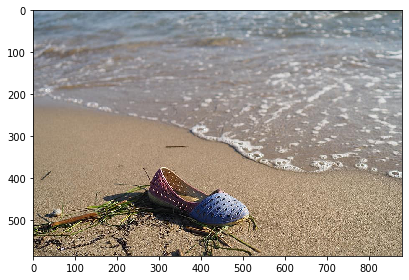

In [44]:
image2 = skimage.io.imread('plastic.jpg')
skimage.io.imshow(image2)

In [20]:
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)
weights_path = model.find_last()
print(weights_path)
model.load_weights(weights_path, by_name=True)



Instructions for updating:
Use `tf.cast` instead.
model/trashconfig20200719T2123/mask_rcnn_trashconfig_0005.h5
Re-starting from epoch 5


['BG', 'trash']


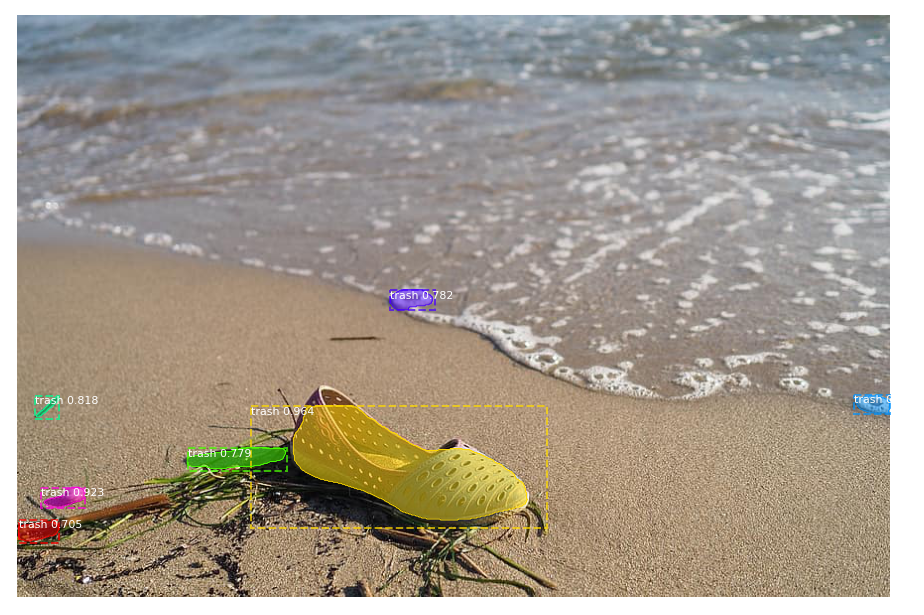

In [45]:
results = model.detect([image2], verbose=0)
r = results[0]
print(dataset.class_names)
visualize.display_instances(image2, r['rois'], r['masks'], r['class_ids'], dataset.class_names, r['scores'])